<a href="https://colab.research.google.com/github/alessandrossC/ML-for-people/blob/main/%22HW_2_2_%D0%9B%D0%BE%D0%B3%D1%96%D1%81%D1%82%D0%B8%D1%87%D0%BD%D0%B0_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%96%D1%8F_%D0%B7_scikit_learn_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [2]:
!pip install opendatasets

In [29]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import opendatasets as od

In [4]:
# Download the dataset
od.download('https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2/data?select=sample_submission.csv')
od.download('https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2/data?select=test.csv')
od.download('https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2/data?select=train.csv')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: oleksandrchekoi
Your Kaggle Key: ··········


100%|██████████| 637k/637k [00:00<00:00, 83.7MB/s]


Extracting archive ./bank-customer-churn-prediction-dlu-course-c-2/bank-customer-churn-prediction-dlu-course-c-2.zip to ./bank-customer-churn-prediction-dlu-course-c-2
Skipping, found downloaded files in "./bank-customer-churn-prediction-dlu-course-c-2" (use force=True to force download)
Skipping, found downloaded files in "./bank-customer-churn-prediction-dlu-course-c-2" (use force=True to force download)


In [5]:
df = pd.read_csv('/content/bank-customer-churn-prediction-dlu-course-c-2/train.csv')
print(df.head())

   id  CustomerId   Surname  CreditScore Geography  Gender   Age  Tenure  \
0   0  15779985.0   Nwankwo        678.0    France    Male  29.0     4.0   
1   1  15650086.0     Ch'in        687.0    France  Female  34.0     1.0   
2   2  15733602.0  Thompson        682.0    France  Female  52.0     6.0   
3   3  15645794.0   Macleod        753.0   Germany    Male  44.0     6.0   
4   4  15633840.0      Hsia        544.0   Germany  Female  55.0     0.0   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00            3.0        1.0             0.0        180626.36   
1       0.00            2.0        0.0             1.0         63736.17   
2       0.00            3.0        0.0             0.0        179655.87   
3   83347.25            2.0        1.0             0.0        161407.48   
4  107747.57            1.0        1.0             0.0        176580.86   

   Exited  
0     0.0  
1     0.0  
2     1.0  
3     0.0  
4     1.0  


In [6]:
input_cols = [col for col in df.columns if col != 'Exited']  # Усі колонки, крім цільової
target_col = 'Exited'  # Назва цільової змінної

# Розбиття даних на train і validation з використанням stratify
train_df, val_df = train_test_split(
    df,
    test_size=0.2,  # 20% для валідації
    stratify=df[target_col],  # Стратіфікація за цільовою змінною
    random_state=42
)

2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [7]:
# Формування наборів даних з .copy()
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

# Перевірка результату
train_inputs.head(), train_targets.head(), val_inputs.head(), val_targets.head()

(          id  CustomerId    Surname  CreditScore Geography  Gender   Age  \
 7180    7180  15652218.0       Mays        682.0    France    Male  30.0   
 10393  10393  15592937.0     Ch'eng        684.0    France  Female  39.0   
 80        80  15774586.0      Ch'in        705.0   Germany    Male  35.0   
 3365    3365  15780572.0         K?        669.0     Spain    Male  58.0   
 12236  12236  15642099.0  Trevisani        707.0    France    Male  21.0   
 
        Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
 7180      1.0  131394.56            1.0        1.0             1.0   
 10393     2.0  178058.06            1.0        1.0             0.0   
 80        6.0  116320.68            2.0        1.0             0.0   
 3365      0.0       0.00            2.0        0.0             1.0   
 12236     3.0       0.00            2.0        1.0             1.0   
 
        EstimatedSalary  
 7180         143952.24  
 10393        145518.31  
 80           174431.01  
 336

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [8]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

# Виведення результатів
numeric_cols, categorical_cols

(['id',
  'CustomerId',
  'CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'],
 ['Surname', 'Geography', 'Gender'])

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [9]:
# Перевірка наявності пропущених значень у тренувальному наборі
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

# Формування таблиці з колонками, які мають пропущені значення
missing_data = pd.DataFrame({
    'Column': missing_values.index,
    'Missing Values': missing_values.values,
    'Missing Percentage': missing_percentage.values
})

# Відфільтруємо лише колонки з пропущеними значеннями
missing_data = missing_data[missing_data["Missing Values"] > 0]
print("Missing Values:")
print(missing_values)

Missing Values:
id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [17]:
# Масштабування числових ознак
scaler = MinMaxScaler()

# One-Hot Encoding для категоріальних змінних
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Об'єднання всіх трансформацій
preprocessor = ColumnTransformer([
    ("num_scale", scaler, numeric_cols),
    ("cat_encode", encoder, categorical_cols)
])  # Видаляємо `remainder='passthrough'` для уникнення дублікатів

# Навчаємо трансформації на train
train_inputs = train_df[input_cols]
val_inputs = val_df[input_cols]
preprocessor.fit(train_inputs)

# Застосовуємо до даних
train_inputs_processed = preprocessor.transform(train_inputs)
val_inputs_processed = preprocessor.transform(val_inputs)

# Отримання оновлених назв колонок після OneHotEncoding
encoded_cat_cols = preprocessor.named_transformers_["cat_encode"].get_feature_names_out(categorical_cols)
all_columns = numeric_cols + list(encoded_cat_cols)

# Переконаємося, що кількість колонок збігається з розміром даних
if len(all_columns) != train_inputs_processed.shape[1]:
    all_columns = [f"feature_{i}" for i in range(train_inputs_processed.shape[1])]

# Перетворення в DataFrame
train_inputs = pd.DataFrame(train_inputs_processed, columns=all_columns)
val_inputs = pd.DataFrame(val_inputs_processed, columns=all_columns)

# Отримання цільових значень
train_targets = train_df[target_col]
val_targets = val_df[target_col]


from IPython.display import display

# Виведення перших 5 рядків з оброблених тренувальних і валідаційних даних
print("Train Inputs Processed (First 5 Rows):")
display(train_inputs.head())

print("Validation Inputs Processed (First 5 Rows):")
display(val_inputs.head())


Train Inputs Processed (First 5 Rows):


,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Surname_Zito,Surname_Zox,Surname_Zuev,Surname_Zuyev,Surname_Zuyeva,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.478699,0.988516,0.599045,0.214286,0.1,0.626382,0.000000,1.0,1.0,0.719772,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.692913,0.984351,0.603819,0.375000,0.2,0.848836,0.000000,1.0,0.0,0.727603,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.005334,0.997112,0.653938,0.303571,0.6,0.554522,0.333333,1.0,0.0,0.872180,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.224348,0.997533,0.568019,0.714286,0.0,0.000000,0.333333,0.0,1.0,0.257797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.815788,0.987805,0.658711,0.053571,0.3,0.000000,0.333333,1.0,1.0,0.742837,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


Validation Inputs Processed (First 5 Rows):


,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Surname_Zito,Surname_Zox,Surname_Zuev,Surname_Zuyev,Surname_Zuyeva,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.432696,0.998500,0.675418,0.500000,0.1,0.551870,1.000000,1.0,1.0,0.364704,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.243083,0.986066,0.386635,0.410714,0.5,0.000000,0.333333,1.0,1.0,0.190942,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.353757,0.998048,0.715990,0.357143,0.2,0.000000,0.333333,0.0,1.0,0.584853,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.043470,0.999135,0.577566,0.446429,0.4,0.742441,0.000000,0.0,1.0,0.558109,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.175145,0.996960,0.589499,0.214286,0.4,0.000000,0.333333,1.0,0.0,0.718420,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


Масштабування числових ознак до діапазону [0, 1].Масштабування знижує вплив ознак із великими числовими значеннями та полегшує роботу моделей, особливо тих, які чутливі до масштабів (наприклад, логістична регресія).

Заповнення пропущених значень у категоріальних колонках найпоширенішим значенням. Найпоширеніше значення — це найбільш ймовірний варіант для заповнення пропусків у категоріях


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [21]:
output_dir = "/mnt/data/processed_data"
os.makedirs(output_dir, exist_ok=True)

In [24]:
# Збереження оброблених даних у форматі Parquet
train_inputs_path = os.path.join(output_dir, "train_inputs.parquet")
val_inputs_path = os.path.join(output_dir, "val_inputs.parquet")
train_targets_path = os.path.join(output_dir, "train_targets.parquet")
val_targets_path = os.path.join(output_dir, "val_targets.parquet")


In [25]:
train_inputs.to_parquet(train_inputs_path)
val_inputs.to_parquet(val_inputs_path)
pd.DataFrame(train_targets).to_parquet(train_targets_path)
pd.DataFrame(val_targets).to_parquet(val_targets_path)

# Виведення списку збережених файлів
saved_files = os.listdir(output_dir)
saved_files

['train_targets.parquet',
 'val_inputs.parquet',
 'train_inputs.parquet',
 'val_targets.parquet']

6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [31]:
# Формування X_train та X_val (всі вхідні дані, крім цільової змінної)
X_train = train_inputs.copy()
X_val = val_inputs.copy()

# Формування y_train та y_val (цільова змінна)
y_train = train_targets.copy()
y_val = val_targets.copy()

# Ініціалізація та навчання моделі LogisticRegression
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# Прогнозування на валідаційних даних
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Оцінка якості моделі
accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba)

# Виведення результатів
accuracy, roc_auc



(0.8706666666666667, 0.8845798751629055)

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

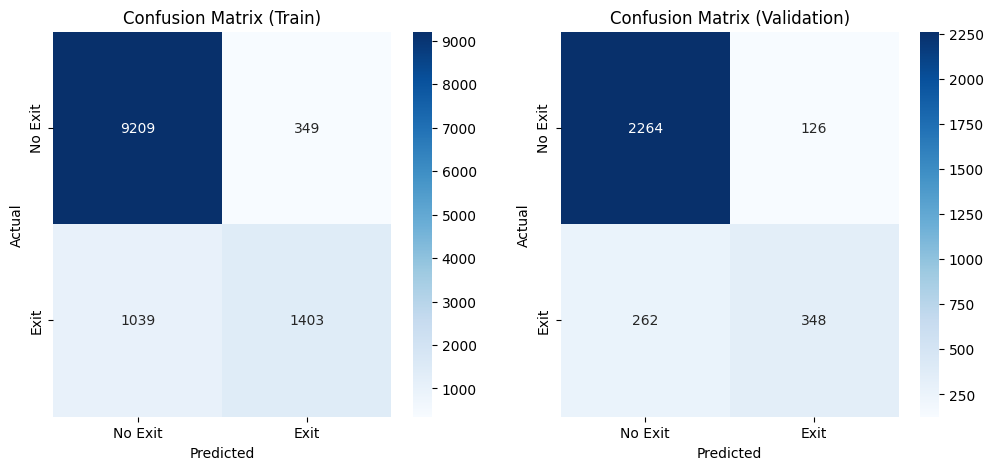

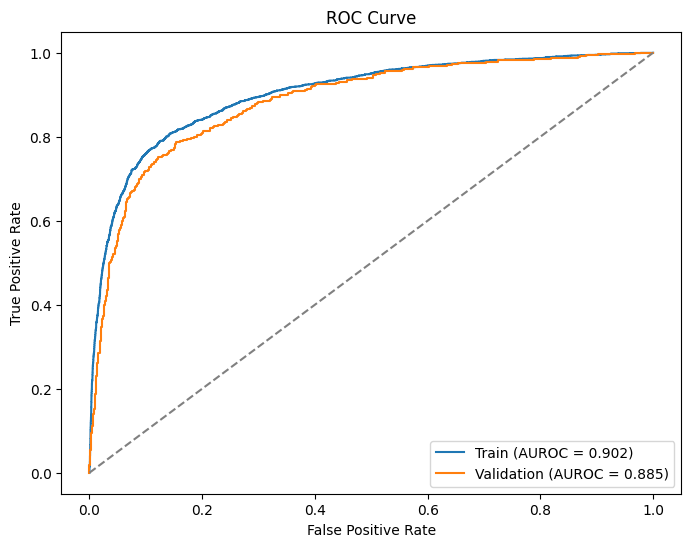

{'Train F1 Score': 0.6690510252742012,
 'Validation F1 Score': 0.6420664206642066,
 'Train AUROC': 0.9020635084665216,
 'Validation AUROC': 0.8845798751629055}

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, f1_score

# Обчислення Confusion Matrix для тренувального та валідаційного набору
cm_train = confusion_matrix(y_train, model.predict(X_train))
cm_val = confusion_matrix(y_val, y_pred)

# Обчислення метрики F1 Score
f1_train = f1_score(y_train, model.predict(X_train))
f1_val = f1_score(y_val, y_pred)

# Побудова ROC-кривої
fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(X_train)[:, 1])
fpr_val, tpr_val, _ = roc_curve(y_val, y_pred_proba)

# Візуалізація Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix для Train
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['No Exit', 'Exit'], yticklabels=['No Exit', 'Exit'], ax=axes[0])
axes[0].set_title('Confusion Matrix (Train)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Confusion Matrix для Validation
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=['No Exit', 'Exit'], yticklabels=['No Exit', 'Exit'], ax=axes[1])
axes[1].set_title('Confusion Matrix (Validation)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.show()

# Візуалізація ROC-кривої
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train (AUROC = {roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]):.3f})')
plt.plot(fpr_val, tpr_val, label=f'Validation (AUROC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Виведення метрик
{
    "Train F1 Score": f1_train,
    "Validation F1 Score": f1_val,
    "Train AUROC": roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
    "Validation AUROC": roc_auc
}


AUROC = 88.5% - гарна якість передбачення.F1 Score = 64% Баланс між точністю та повнотою.

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [33]:
# Визначення мажоритарного класу (класу, який зустрічається частіше за все у train_targets)
majority_class = y_train.value_counts().idxmax()

# Створення прогнозу "завжди мажоритарний клас" для тренувального та валідаційного наборів
y_train_majority_pred = np.full_like(y_train, majority_class)
y_val_majority_pred = np.full_like(y_val, majority_class)

# Обчислення Accuracy для простої моделі (мажоритарний клас)
accuracy_train_majority = accuracy_score(y_train, y_train_majority_pred)
accuracy_val_majority = accuracy_score(y_val, y_val_majority_pred)

# Обчислення Accuracy для натренованої Logistic Regression моделі
accuracy_train_model = accuracy_score(y_train, model.predict(X_train))
accuracy_val_model = accuracy_score(y_val, y_pred)

# Виведення результатів
{
    "Majority Class": majority_class,
    "Train Accuracy (Majority)": accuracy_train_majority,
    "Validation Accuracy (Majority)": accuracy_val_majority,
    "Train Accuracy (Model)": accuracy_train_model,
    "Validation Accuracy (Model)": accuracy_val_model,
}


{'Majority Class': 0.0,
 'Train Accuracy (Majority)': 0.7965,
 'Validation Accuracy (Majority)': 0.7966666666666666,
 'Train Accuracy (Model)': 0.8843333333333333,
 'Validation Accuracy (Model)': 0.8706666666666667}

Модель є хорошою, оскільки вона перевищує базову стратегію (мажоритарний клас) та має високу AUROC приблизно 88%


9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [34]:
import joblib

# Шлях для збереження моделі
model_path = "/mnt/data/log_reg.joblib"

# Збереження моделі
joblib.dump(model, model_path)

# Завантаження моделі з файлу
model_2 = joblib.load(model_path)

# Перевірка, чи завантажена модель ідентична оригінальній (порівняння коефіцієнтів)
np.allclose(model.coef_, model_2.coef_)


True

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [36]:
import warnings

# Ігнорування попереджень
warnings.filterwarnings("ignore")

def predict_raw_df(preprocessor, model, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    # Копія вхідних даних, щоб уникнути змін у оригінальному DataFrame
    input_df = input_df.copy()

    # Переконуємося, що потрібні колонки є у вхідних даних
    missing_cols = [col for col in numeric_cols + categorical_cols if col not in input_df.columns]
    if missing_cols:
        raise ValueError(f"Відсутні колонки у вхідних даних: {missing_cols}")

    # Застосування навченої трансформації до вхідних даних
    X_input = preprocessor.transform(input_df[numeric_cols + categorical_cols])

    # Отримання ймовірностей класу 1
    prob = model.predict_proba(X_input)[:, 1]

    return prob

In [39]:
predict_raw_df(preprocessor, model, numeric_cols, categorical_cols, df[:5])

array([0.00617054, 0.02975421, 0.6169147 , 0.31788778, 0.97539206])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [50]:
# Завантаження test.csv
test_file_path = "/content/bank-customer-churn-prediction-dlu-course-c-2/test.csv"

test_raw_df = pd.read_csv(test_file_path)

# Отримання прогнозів для кожного рядка тестових даних
test_raw_df["Exited"] = predict_raw_df(preprocessor, model, numeric_cols, categorical_cols, test_raw_df)

# Відображення оновленого датафрейму
print(test_raw_df.head())

      id  CustomerId     Surname  CreditScore Geography Gender   Age  Tenure  \
0  15000  15594796.0         Chu        584.0   Germany   Male  30.0     2.0   
1  15001  15642821.0       Mazzi        551.0    France   Male  39.0     5.0   
2  15002  15716284.0   Onyekachi        706.0    France   Male  43.0     8.0   
3  15003  15785078.0      Martin        717.0     Spain   Male  45.0     3.0   
4  15004  15662955.0  Kenechukwu        592.0     Spain   Male  43.0     8.0   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0  146053.66            1.0        1.0             1.0        157891.86   
1       0.00            2.0        1.0             1.0         67431.28   
2       0.00            2.0        1.0             0.0        156768.45   
3       0.00            1.0        1.0             1.0        166909.87   
4       0.00            2.0        1.0             1.0        143681.97   

     Exited  
0  0.022522  
1  0.048720  
2  0.074365  
3  0.299841 

12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [52]:
# Завантаження sample_submission.csv
submission_file_path = "/content/bank-customer-churn-prediction-dlu-course-c-2/sample_submission.csv"

# Читаємо файл
submission_df = pd.read_csv(submission_file_path)

submission_df['Exited'] = submission_df['id'].map(test_raw_df.set_index('id')['Exited'])

# Виведення перших 5 рядків фінального датасету
print(submission_df.head())

# Збереження у файл без індексів
submission_csv_path = "/content/bank-customer-churn-prediction-dlu-course-c-2/submission_log_reg.csv"
submission_df.to_csv(submission_csv_path, index=False)

      id    Exited
0  15000  0.022522
1  15001  0.048720
2  15002  0.074365
3  15003  0.299841
4  15004  0.036270
